[IMDB DATASET](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews?resource=download)

In [1]:
# ! pip3 install torch --index-url https://download.pytorch.org/whl/cu118

In [2]:
# ! pip install scikit-learn

In [3]:
import numpy as np
import pandas as pd
import torch
import nltk
import torch.nn as nn # for our model class
import torch.nn.functional as F
from nltk.corpus import stopwords # to remove stop words
from collections import Counter # to count unique numbers
import string
import re
import seaborn as sns # for plotting
import matplotlib.pyplot as plt # for plotting
from torch.utils.data import TensorDataset, DataLoader # data prep
from sklearn.model_selection import train_test_split # splitting the dataset for training and testing 

In [4]:
# specify the nltk data path
nltk.data.path.append("/Sentiment Analysis/nltk_data")

In [5]:
# Enable cuda (GPU) if exist. This allows for faster computation

is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")


GPU is available


In [6]:
df = pd.read_csv("IMDB Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


# Split dataset into 2 portions, Training and Testing

In [7]:
df.shape

(50000, 2)

- The `stratify` parameter in the `train_test_split` function ensures that the class distribution in the target labels is preserved in both the training and testing set
- By using `stratify=y`, the splitting process will attempt to maintain the same class proportions in both the training and testing sets.

In [8]:
X, y = df["review"].values, df["sentiment"].values
x_train, x_test, y_train, y_test = train_test_split(X, y, stratify=y)
print(f"Shape of train data is {x_train.shape}")
print(f"Shape of test data is {x_test.shape}")

Shape of train data is (37500,)
Shape of test data is (12500,)


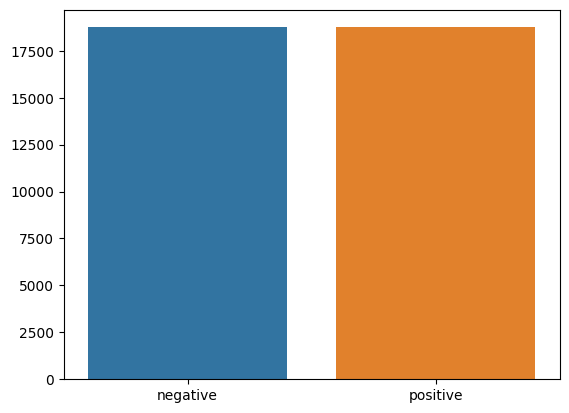

In [9]:
dd = pd.Series(y_train).value_counts()
# sns.barplot(x=np.array(['negative','positive']),y=dd.values)
sns.barplot(x=['negative','positive'],y=dd.values)
plt.show()

In [10]:
dd

negative    18750
positive    18750
Name: count, dtype: int64

In [11]:
dd.values

array([18750, 18750], dtype=int64)

# PreProcess Data

In [12]:
def preprocess_string(s):
    # Remove all non-word characters, ^\w\s except word and space
    s = re.sub(r"[^\w\s]", "", s)
    # Repalce all runs of whitespaces with no space
    s = re.sub(r"\s+", "", s)
    # replace digits with no space
    s = re.sub(r"\d", "", s)

    return s

In [13]:
            # final_list_train.append([
            #     onehot_dict[preprocess_string(word)]
            #     for word in sent.lower().split 
            #     if preprocess_string(word) in onehot_dict.keys()])

In [14]:
def remove_stop_words(data):
    word_list = []
    stop_words = set(stopwords.words("english"))
    for sent in data:
        for word in sent.lower().split():  # lower case sentence splitted in list
            word = preprocess_string(word) # preprocess that word
            if word not in stop_words and word != "":
                word_list.append(word) # if not stop word then append
    return word_list

In [15]:
x_train[:1]

array(['When naïve young Eddie Hatch, a window dresser at Savory\'s Department Store, falls for a statue of Venus and gives her a chaste kiss, Venus steps off her pedestal and gives Eddie more than he bargained for. This creaking example of what Hollywood can do to a Broadway musical manages to emphasize the inane story and eliminate most of the first-rate songs. The purpose was to make a safe, popular movie without too much investment while capitalizing on Ava Gardner\'s upward mobility to super stardom. Robert Walker as Eddie gets lost in a thankless role. Eddie\'s not just naive, but dithering and hapless. Gardner is gorgeous, but the only things that give the movie any life are Olga San Juan as Eddie\'s loving but jealous girl friend, Tom Conway as the suave owner of Savory\'s and Eve Arden as Savory\'s long time, wise cracking secretary. It\'s a role Arden could play in her sleep, and she\'s good at it. <br /><br />The musical opened on Broadway in 1943 and made Mary Martin a big-

In [16]:
x_train[0].split

<function str.split(sep=None, maxsplit=-1)>

In [17]:
print(remove_stop_words(x_train[:1]))

['naïve', 'young', 'eddie', 'hatch', 'window', 'dresser', 'savorys', 'department', 'store', 'falls', 'statue', 'venus', 'gives', 'chaste', 'kiss', 'venus', 'steps', 'pedestal', 'gives', 'eddie', 'bargained', 'creaking', 'example', 'hollywood', 'broadway', 'musical', 'manages', 'emphasize', 'inane', 'story', 'eliminate', 'firstrate', 'songs', 'purpose', 'make', 'safe', 'popular', 'movie', 'without', 'much', 'investment', 'capitalizing', 'ava', 'gardners', 'upward', 'mobility', 'super', 'stardom', 'robert', 'walker', 'eddie', 'gets', 'lost', 'thankless', 'role', 'eddies', 'naive', 'dithering', 'hapless', 'gardner', 'gorgeous', 'things', 'give', 'movie', 'life', 'olga', 'san', 'juan', 'eddies', 'loving', 'jealous', 'girl', 'friend', 'tom', 'conway', 'suave', 'owner', 'savorys', 'eve', 'arden', 'savorys', 'long', 'time', 'wise', 'cracking', 'secretary', 'role', 'arden', 'could', 'play', 'sleep', 'shes', 'good', 'br', 'br', 'musical', 'opened', 'broadway', 'made', 'mary', 'martin', 'bigtime

In [18]:
word_counter = Counter(remove_stop_words(x_train[:1]))

In [19]:
word_counter.get("give")

1

In [20]:
count_list = sorted(word_counter, key=word_counter.get, reverse=True)[:10]
count_list

['br',
 'one',
 'songs',
 'movie',
 'venus',
 'broadway',
 'music',
 'ronell',
 'song',
 'eddie']

In [21]:
global_hot_dict = {w:i+1 for i,w in enumerate(count_list)}
global_hot_dict

{'br': 1,
 'one': 2,
 'songs': 3,
 'movie': 4,
 'venus': 5,
 'broadway': 6,
 'music': 7,
 'ronell': 8,
 'song': 9,
 'eddie': 10}

In [22]:
def get_number_of_word(data, onehot_dict):
    # picking the number of the word after preprocessing it
    final_list_data = []
    for sent in data:
        # final_list_data.extend(
        final_list_data.append(
            [
                onehot_dict[preprocess_string(word)]
                for word in sent.lower().split()
                if preprocess_string(word) in onehot_dict.keys()
            ]
        )
    return final_list_data

In [23]:
def encode_label(data):
    return [1 if label =='positive' else 0 for label in data] 

In [24]:
from dataclasses import dataclass

@dataclass
class Tokenize:
    # x_train: np.array
    x_train: list
    y_train: list
    # x_test: np.array
    x_test: list
    y_test: list
    vocab: dict

In [25]:
def tokenize(x_train, y_train, x_val, y_val):
    word_list = remove_stop_words(x_train)

    corpus = Counter(word_list) # counting the words occurence
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:1000]

    # creating a dict
    # this will create a dictionary with their numbers based on most common words
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}

    # tokenize
    final_list_train = get_number_of_word(x_train, onehot_dict)
    final_list_test = get_number_of_word(x_val, onehot_dict)

    # encoding the labels 
    encoded_train = encode_label(y_train)
    encoded_test = encode_label(y_val)

    #returning these 4 values
    # result = Tokenize(np.array(final_list_train), np.array(encoded_train), np.array(final_list_test), np.array(encoded_test), onehot_dict)
    result = Tokenize(final_list_train, np.array(encoded_train), final_list_test, np.array(encoded_test), onehot_dict)
    return result


In [26]:
tokenized_output = tokenize(x_train,y_train,x_test,y_test)

In [27]:
print(f'Length of vocabulary is {len(tokenized_output.vocab)}') 

Length of vocabulary is 1000


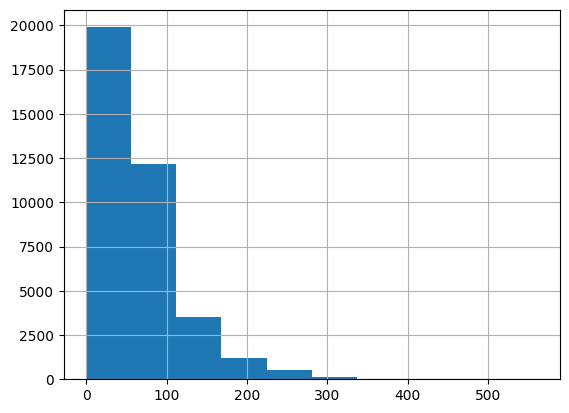

count    37500.000000
mean        69.216507
std         48.132736
min          0.000000
25%         39.000000
50%         54.000000
75%         84.000000
max        561.000000
dtype: float64

In [28]:
# analyze the length of the sequences in order to padd them
rev_len = [len(i) for i in tokenized_output.x_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

- Most of the reviews lie between 0-100 and some of them lie in 200-400 range

## Padding
- Since the reviews are not of the same length we'll need to pad the sequences
- Many different research papers suggested that padding 0s to the sequence tend to improve the performance of the model a lot
- In order to make sure that no information is missed out, we can padd the sequences to the maximum sequence length which is nearly 400-500 as shown in graph. 
    - we've very less # of reviews with length > 500

In [29]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features 

In [30]:
# def padding(sentences, seq_len):
#     features = []
#     for review in sentences:
#         padded_review = review[:seq_len] + [0] * max(0, seq_len - len(review))
#         features.append(padded_review[:seq_len])
#     return np.array(features, dtype=int)

In [31]:
x_train_pad = padding_(tokenized_output.x_train, 500)
x_test_pad = padding_(tokenized_output.x_test, 500)

In [32]:
x_train_pad.shape, x_test_pad.shape

((37500, 500), (12500, 500))

# Initializing for PyTorch

In [34]:
x_train_pad.dtype

dtype('int32')

In [37]:
# this isn't supported so we'll change its type
y_train.dtype

dtype('O')

In [42]:
tokenized_output.y_train.dtype

dtype('int32')

In [41]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(tokenized_output.y_train))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(tokenized_output.y_test))

# batch size
batch_size = 50

#shuffling
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

In [50]:
train_data.tensors, len(train_data.tensors)

((tensor([[  0,   0,   0,  ..., 490,  64,  42],
          [  0,   0,   0,  ...,  32, 145,  60],
          [  0,   0,   0,  ...,  54, 122,   1],
          ...,
          [  0,   0,   0,  ...,  27,  30, 126],
          [  0,   0,   0,  ..., 539,  29, 170],
          [  0,   0,   0,  ..., 202,  31, 117]], dtype=torch.int32),
  tensor([0, 1, 0,  ..., 1, 1, 1], dtype=torch.int32)),
 2)

# Define LSTM model with word embeddings
## Word Embeddings
 Word embeddings are a popular technique used in natural language processing (NLP) to represent words as dense vector representations in a continuous vector space. 
    - They capture semantic and syntactic relationships between words, allowing machine learning models to understand the meaning and context of words

## What we'll use?
- we'll use simple Word Embedding layer, but we can use pre-trained layers to further improve the model results

---
- init_hidden state: this tends to affect the performance
    - [Pytorch Official Discussion](https://discuss.pytorch.org/t/when-to-initialize-lstm-hidden-state/2323/2)

In [68]:
class SentimentRNN(nn.Module): # class name
    def __init__(self,no_layers,vocab_size,hidden_dim, output_dim, embedding_dim, drop_prob=0.4): 
        super(SentimentRNN,self).__init__() # initializing base class

        self.output_dim = output_dim # output dimensions
        self.hidden_dim = hidden_dim # hidden dimensions

        self.no_layers = no_layers # number of layers
        self.vocab_size = vocab_size # vocabulary size

        # embedding 
        # embedding of vocabulary size and embedding dimensions
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)

        # dropout layer
        self.dropout = nn.Dropout(drop_prob) 
    
        # linear and sigmoid layer
        self.fc0 = nn.Linear(self.hidden_dim, 512) # first drop out
        self.fc1 = nn.Linear(512, 256) # 1st fc layer
        self.dropout1 = nn.Dropout(0.2) # 2nd drop out
        self.fc = nn.Linear(256, output_dim) # 2nd fully connected layer
        self.sig = nn.Sigmoid() # for last layer

    def forward(self, x, hidden):
        batch_size = x.size(0) # fetching batch size
        # embeddings and lstm_out
        # shape: Batch x S x Feature   since batch = True
        embeds = self.embedding(x)
        # passing our embedded layer into lstm
        lstm_out, hidden = self.lstm(embeds, hidden) 
        # reshaping the lstm output, so we can pass it to fully connected layers
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)

        # dropout and fully connected layer
        out = self.dropout(lstm_out) 
        out = self.fc0(out)
        out = self.dropout1(out)
        out = self.fc1(out)
        out = self.fc(out)

        # sigmoid function for binary classification output
        sig_out = self.sig(out) 

        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)

        sig_out = sig_out[:, -1] # get last batch of labels

        # return last sigmoid output and hidden state
        return sig_out, hidden

    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers, batch_size, self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers, batch_size, self.hidden_dim)).to(device)
        hidden = (h0, c0)
        return hidden
 

In [69]:
len(tokenized_output.vocab)

1000

In [70]:
no_layers = 4 # 4 hidden LSTM stacked layers
vocab_size = len(tokenized_output.vocab) + 1 # extra 1 for padding
embedding_dim = 64 #  embedding dimensions
output_dim = 1 # single output 1 or 0
hidden_dim = 256 #  hidden dimensions
model = SentimentRNN(no_layers, vocab_size, hidden_dim, output_dim, embedding_dim, drop_prob=0.5)

# moving to gpu if available
model.to(device) 

SentimentRNN(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=4, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc0): Linear(in_features=256, out_features=512, bias=True)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)

In [71]:
print(model)

SentimentRNN(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=4, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc0): Linear(in_features=256, out_features=512, bias=True)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [72]:
def acc(pred, label):
    pred = torch.round(pred.squeeze()) # remove extra dimensions
    return torch.sum(pred == label.squeeze()).item()  # correct predictions vs label  

In [73]:
# hyperparameters for the model
lr=0.001 # learning rate
criterion = nn.BCELoss() # binary cross entropy for binary classification
optimizer = torch.optim.Adam(model.parameters(), lr=lr) # adam optimizer
 

In [74]:
clip = 5 # gradient clipping for exploding gradients
epochs = 10 # number of epochs
valid_loss_min = np.Inf # setting loss for minimum i.e infinity epochs

# train for some number of epochs
epoch_tr_loss, epoch_vl_loss = [],[]  # lists for appending per epochs statistics to visualize
epoch_tr_acc, epoch_vl_acc = [],[]

In [75]:
for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train() # set the model in training mode
    # initialize hidden state 
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader: # training data
        inputs, labels = inputs.to(device), labels.to(device)   
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h]) 

        model.zero_grad() # zero gradients before starting the training
        output, h = model(inputs, h) # forward pass

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float()) # criterion loss
        loss.backward() # computes loss
        train_losses.append(loss.item()) # appending the loss
        # calculating accuracy
        accuracy = acc(output,labels) 
        train_acc += accuracy 

        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step() # improving the loss via optimizer using back prop (ADAM optimizer)

    val_h = model.init_hidden(batch_size) # initialize the hidden state
    val_losses = []
    val_acc = 0.0
    model.eval() # Putting model into evaluation mode
    for inputs, labels in valid_loader: # validation data
        # separate variable for hidden state
        val_h = tuple([each.data for each in val_h])

        inputs, labels = inputs.to(device), labels.to(device) # checking if gpu or not

        output, val_h = model(inputs, val_h) # forward pass
        val_loss = criterion(output.squeeze(), labels.float()) # loss

        val_losses.append(val_loss.item()) # appending loss

        accuracy = acc(output,labels)
        val_acc += accuracy

    # mean of the loss for calculating epoch loss
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses) # same for validation loss
    epoch_train_acc = train_acc / len(train_loader.dataset) # acc for epoch
    epoch_val_acc = val_acc / len(valid_loader.dataset) # vali acc for epoch
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch + 1}') 
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc * 100} val_accuracy : {epoch_val_acc * 100}')
    if epoch_val_loss <= valid_loss_min:
        # saving the model in dictionary in .pt format
        torch.save(model.state_dict(), './working/state_dict.pt') 
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print(25*'==') # for epoch ending symbol

Epoch 1
train_loss : 0.660942845582962 val_loss : 0.6931323623657226
train_accuracy : 57.08266666666667 val_accuracy : 50.0
Validation loss decreased (inf --> 0.693132).  Saving model ...
Epoch 2
train_loss : 0.5739843263626099 val_loss : 0.4198133869171143
train_accuracy : 66.24 val_accuracy : 81.42399999999999
Validation loss decreased (0.693132 --> 0.419813).  Saving model ...
Epoch 3
train_loss : 0.3516171337167422 val_loss : 0.32952248632907866
train_accuracy : 85.03466666666667 val_accuracy : 85.816
Validation loss decreased (0.419813 --> 0.329522).  Saving model ...
Epoch 4
train_loss : 0.3104766700764497 val_loss : 0.32020457726716994
train_accuracy : 86.93333333333332 val_accuracy : 86.11999999999999
Validation loss decreased (0.329522 --> 0.320205).  Saving model ...
Epoch 5
train_loss : 0.2843270971775055 val_loss : 0.3208598446846008
train_accuracy : 87.97066666666666 val_accuracy : 86.52
Epoch 6
train_loss : 0.2547190594424804 val_loss : 0.3216432208120823
train_accuracy :

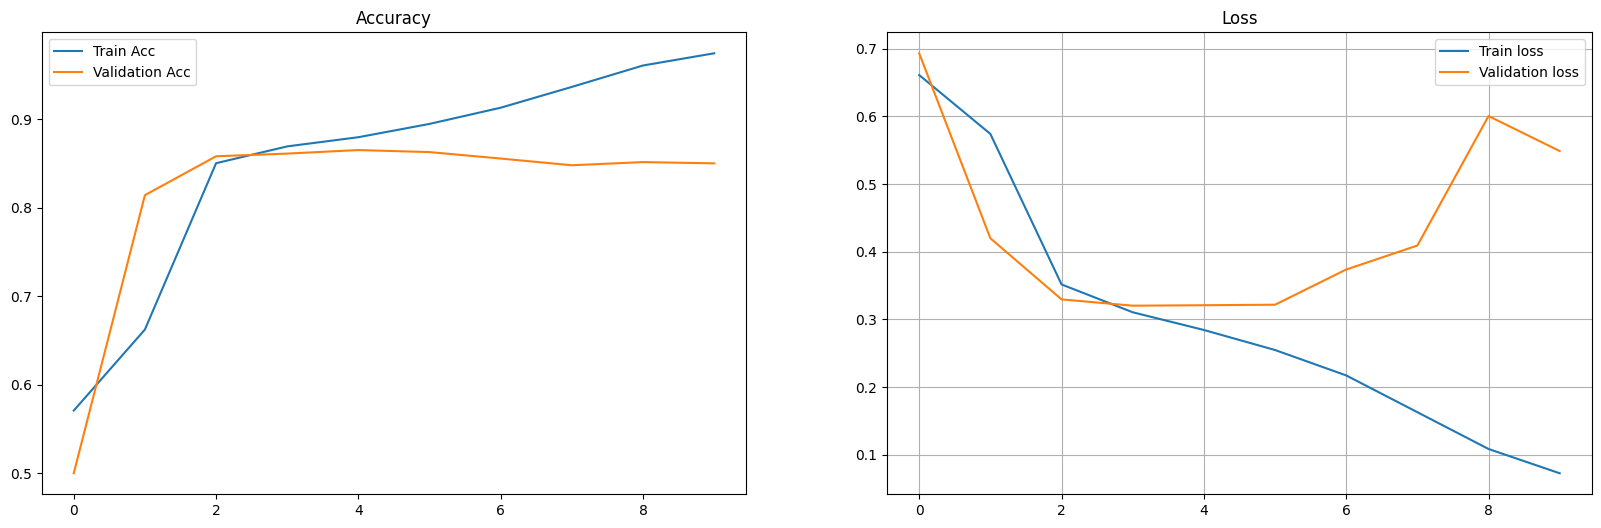

In [76]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc') # training list
plt.plot(epoch_vl_acc, label='Validation Acc') # validation list
plt.title("Accuracy")
plt.legend() 
plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss') # training loss
plt.plot(epoch_vl_loss, label='Validation loss') # validation loss
plt.title("Loss")
plt.legend()
plt.grid() # grid 
plt.show() # showing the plots

- Our model overfits, which can be fixed by regularization, dropout or batch normalization

In [77]:
def predict_text(text, vocab=tokenized_output.vocab):
    word_seq = np.array([vocab[preprocess_string(word)] for word in text.split() 
                        if preprocess_string(word) in vocab.keys()]) #preprocess data
    word_seq = np.expand_dims(word_seq,axis=0) #expanding the dimensions for lstm
    pad =  torch.from_numpy(padding_(word_seq,500)) #padding the sequences
    inputs = pad.to(device) #checking if gpu or not
    batch_size = 1 #batch size 1 for 1 input at 1 time
    h = model.init_hidden(batch_size) #initializing the hidden state
    h = tuple([each.data for each in h]) # hidden state variable
    output, h = model(inputs, h) #forward pass through the model
    return(output.item()) #returning the output from sigmoid 

In [78]:
import random
index = random.randint(0,25000)
print(df['review'][index])
print(80*'=')
print("Actual Sentiment is ", df['sentiment'][index])
pro = predict_text(df['review'][index])
sent = 'positive' if pro >=0.5 else 'negative'
print("Predicted Sentiment is ", sent, " with a probability of ", pro)

Many accuse Rod Steiger of overacting, and anyone who has seen the Amityville Horror and the 'fly' section would struggle to say otherwise. That said, he's brilliant in this.<br /><br />It's never on TV, you can't buy it on DVD (legitimately). In 1988, when Channel 4 still had a prescription for innovation, they showed this amongst a small amalgam of 60s films, Privilege etc - and I remember an essentially theatrical experience, transposed well to film. The great thing about theatre is it's enclosed - how do you make it available and interesting on screen? PH just about pulls it off. Because this sort of film is never even on cable or Sky TV anywhere it's hard to get a debate going, but for anyone out there who has seen it or can remember, my memories are of a forthright, almost strident performance by Sally Geeson 'thats all taken care of' (which eschews the almost diffident general performances of her and her sibling in many early 70s offerings) she says ref conception. There are sev

# How to Improve the model

- We can improve the model via
1. Regularization
2. Hyperparameter Tuning
3. Adding more layers
4. Using Bi-Directional LSTMs
5. Using Pre-trained Word Embedding such as Glove or Word2Vec, etc.

# Future todo
- [Deploying Sentiment Analysis through k8s](https://app.cnvrg.io/docs/core_concepts/endpoints.html)
- [Real-time Sentiment Analysis](https://cnvrg.io/web-services-vs-streaming/)